# 0. Introdução

**Trabalho**:

Aluno: Maicon Dall'Agnol

R.A.: 151161868

Disciplina: Tópico em Aprendizado de Máquina

**Objetivos** :

- Escolha dois datasets rotulados.
- Realize a análise estatística, visualização e pré-processamento dos dados.
-  Realize os experimentos criando duas bases de teste distintas:
- - considerando todos os atributos do dataset;
- - selecionando alguns atributos e descartando outros.
- Aplique três métodos de classificação distintos nas duas bases acima referentes a cada dataset.
- Para cada dataset, em cada uma das bases, analise os resultados segundo medidas de qualidade de classificação, usando índices de validação externa (acurácia, recall, precisão, F-measure, índice Kappa) e cruva ROC.
- Proponha uma maneira adicional de comparar os resultados obtidos além das medidas acima.
- Compare e interprete os resultados dos dois experimentos em cada dataset.
- Faça tabela com as medidas de validação

## 0.1 Dependências

Para realização da tarefa foram utilizados as seguintes bibliotecas:

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# KFold
from sklearn.model_selection import KFold
import random

# Classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from  sklearn.metrics  import  roc_auc_score 
from sklearn.metrics import balanced_accuracy_score

#Visualização
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Dados

Este conjunto de dados classifica as pessoas descritas por um conjunto de atributos como riscos de crédito bons ou ruins

## 1.1 Informações sobre os dados:

#### Atributos:
- Status da conta corrente existente, no marco alemão.
- Duração em meses
- Histórico de crédito (créditos recebidos, devolução devida, atrasos, contas críticas)
- Objetivo do crédito (carro, televisão, ...)
- Quantidade de crédito
- Situação da conta-poupança / títulos, no marco alemão.
- Emprego atual, em número de anos.
- Taxa de parcelamento em percentagem do rendimento disponível
- Estatuto pessoal (casado, solteiro, ...) e sexo
- Outros devedores / fiadores
- Residência atual desde X anos
- Propriedade (por exemplo, imóveis)
- Idade em anos
- Outros planos de parcelamento (bancos, lojas)
- Habitação (aluguel, próprio, ...)
- Número de créditos existentes neste banco
- Trabalho
- Número de pessoas susceptíveis de fornecer manutenção para
- Telefone (sim, não)
- trabalhador estrangeiro (sim, não)

#### Classe:
- Class



## Importando Dataset

In [3]:
data_credit_raw = pd.read_csv('dataset_31_credit-g.csv')

In [4]:
pandas_profiling.ProfileReport(data_credit_raw)

Number of variables,21
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,164.1 KiB
Average record size in memory,168.1 B
Numeric,6
Categorical,14
Boolean,1
Date,0
Text (Unique),0
Rejected,0


## Dividindo valores de atributos

In [5]:
dict_data = data_credit_raw.to_dict(orient='records')

In [6]:
for line in dict_data:
    splited = line['personal_status'].split(sep=' ')
    line['sex'] = splited[0]
    line['personal_status'] = splited[1]

In [7]:
data_credit = pd.DataFrame(dict_data)
aux = data_credit['class']
data_credit.drop(columns=['class'], inplace = True)
data_credit['class'] = aux

## Visualização

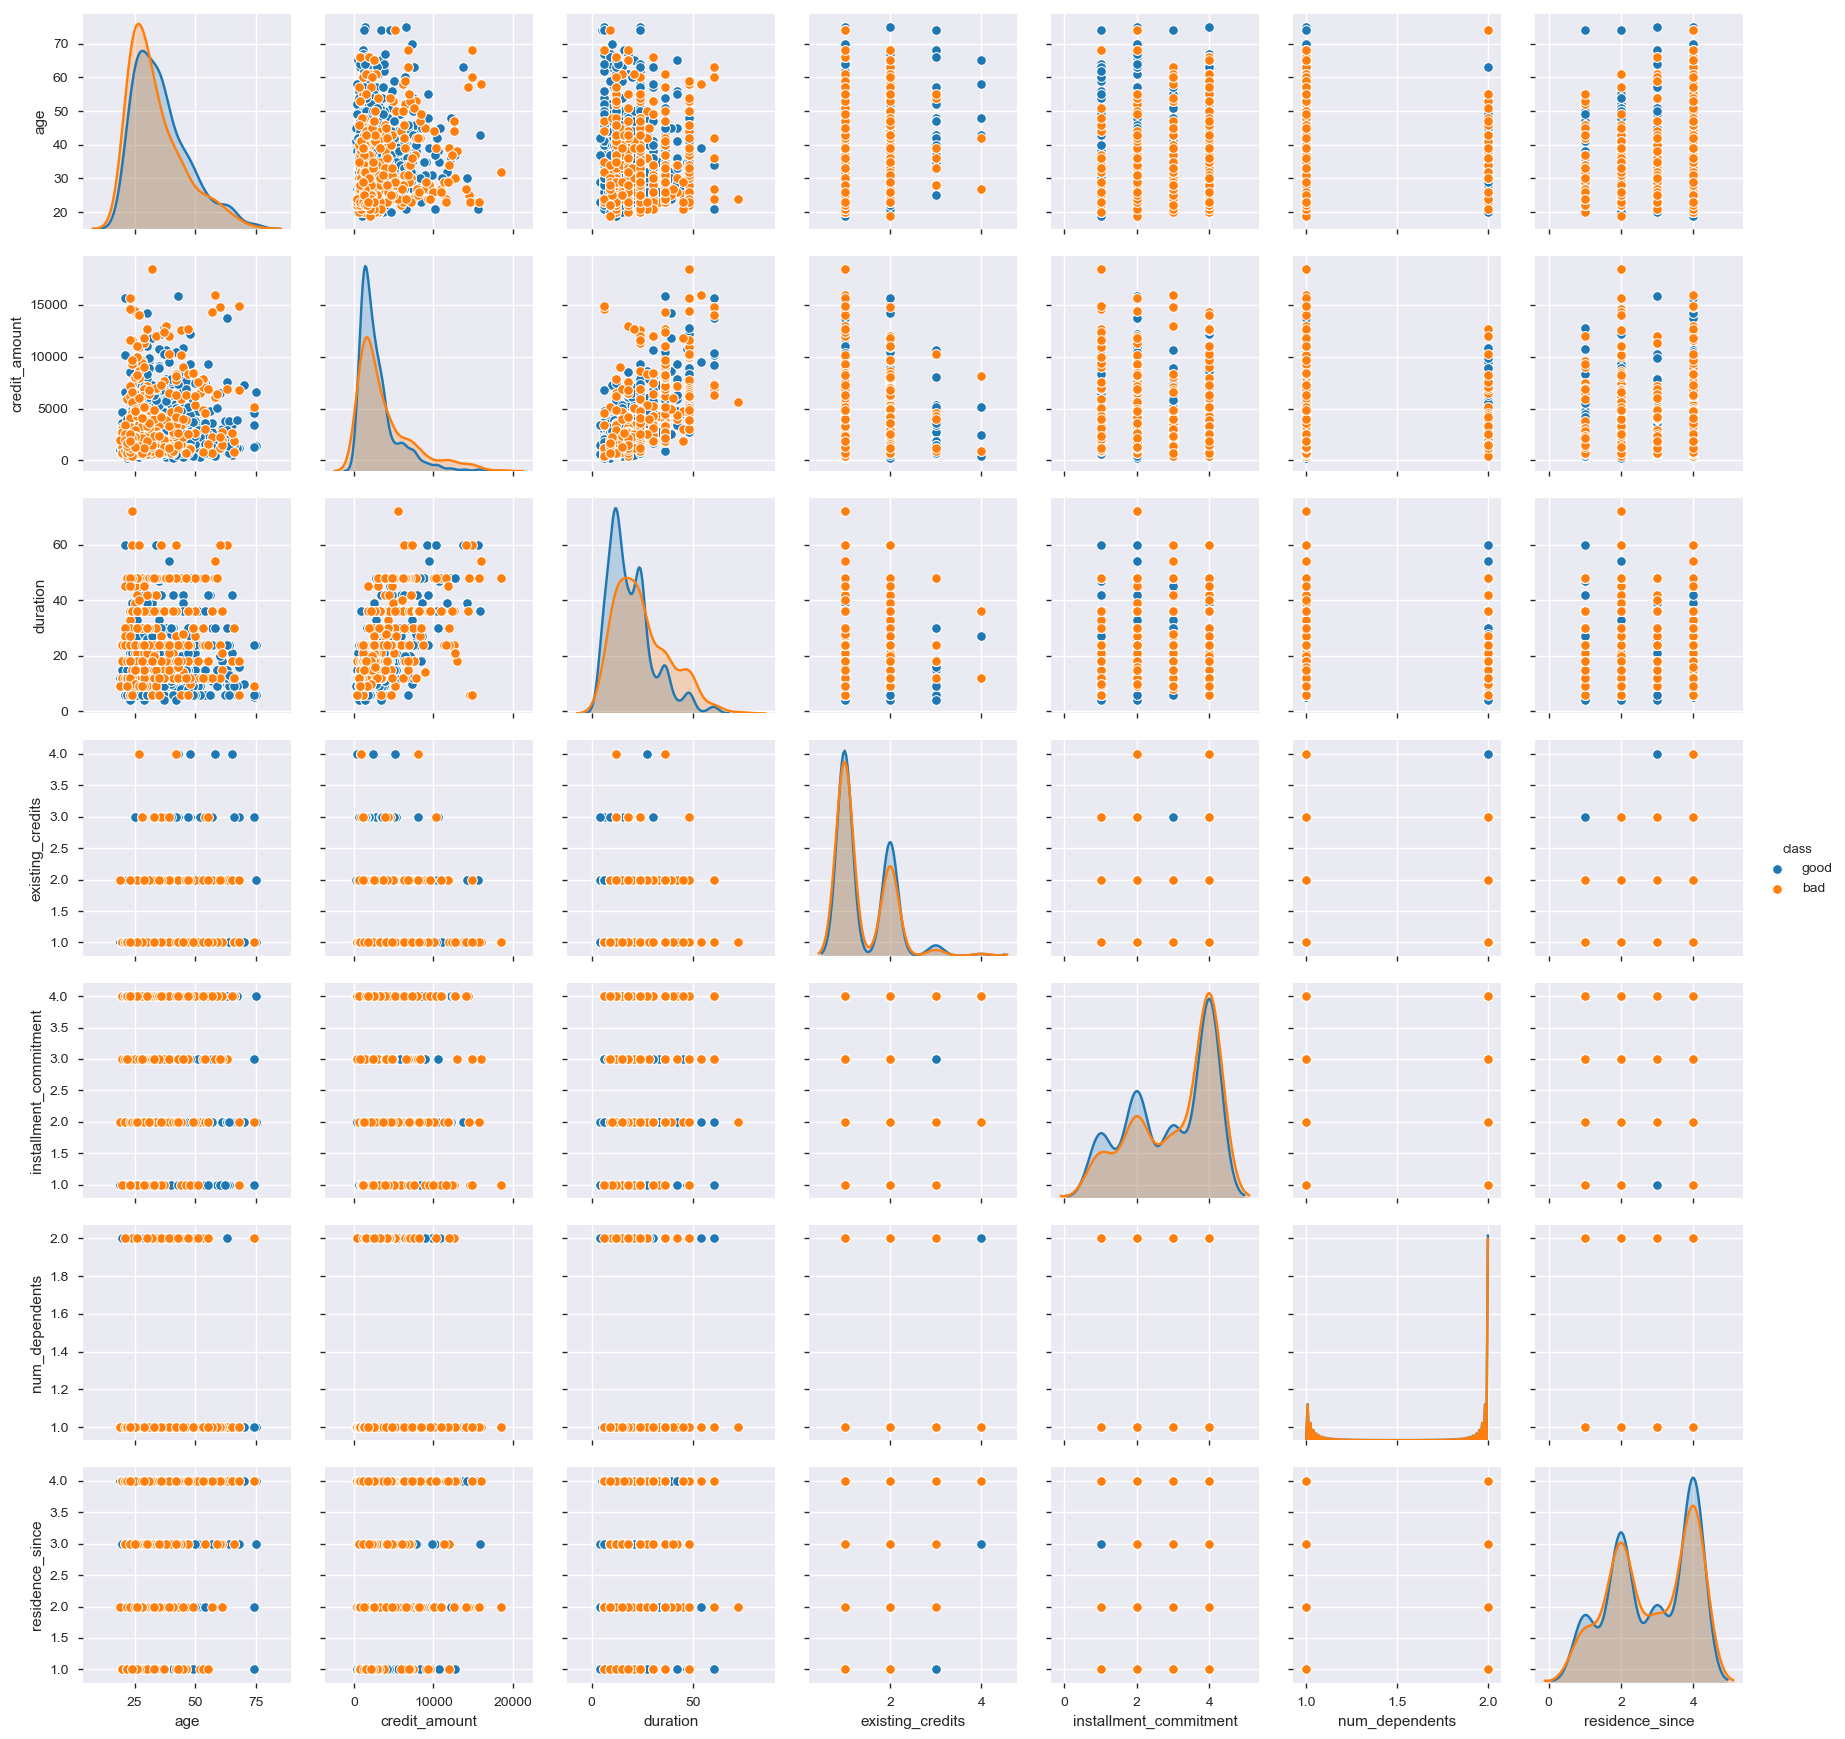

In [8]:
sns.pairplot(data_credit, diag_kind="kde",hue='class')

## Transformação

In [9]:
data_credit_lb = data_credit.copy()

In [10]:
def list_attrib_categor(data):
    atributos_categoricos = []
    
    for atributo, tipo in zip(data.columns, data.dtypes):
        if tipo == object:
            atributos_categoricos.append(atributo)
            
    return atributos_categoricos

In [11]:
for atribute in list_attrib_categor(data_credit_lb):
    le = LabelEncoder()
    data_credit_lb[atribute] = le.fit_transform(data_credit[atribute].values)

In [12]:
data_credit_lb.head()

,age,checking_status,credit_amount,credit_history,duration,employment,existing_credits,foreign_worker,housing,installment_commitment,...,other_parties,other_payment_plans,own_telephone,personal_status,property_magnitude,purpose,residence_since,savings_status,sex,class
0,67,1,1169,1,6,3,2,1,1,4,...,2,1,1,3,2,7,4,4,1,1
1,22,0,5951,3,48,0,1,1,1,2,...,2,1,0,0,2,7,2,2,0,0
2,49,3,2096,1,12,1,1,1,1,2,...,2,1,0,3,2,4,3,2,1,1
3,45,1,7882,3,42,1,1,1,0,2,...,1,1,0,3,0,5,4,2,1,1
4,53,1,4870,2,24,0,2,1,0,3,...,2,1,0,3,1,1,4,2,1,0


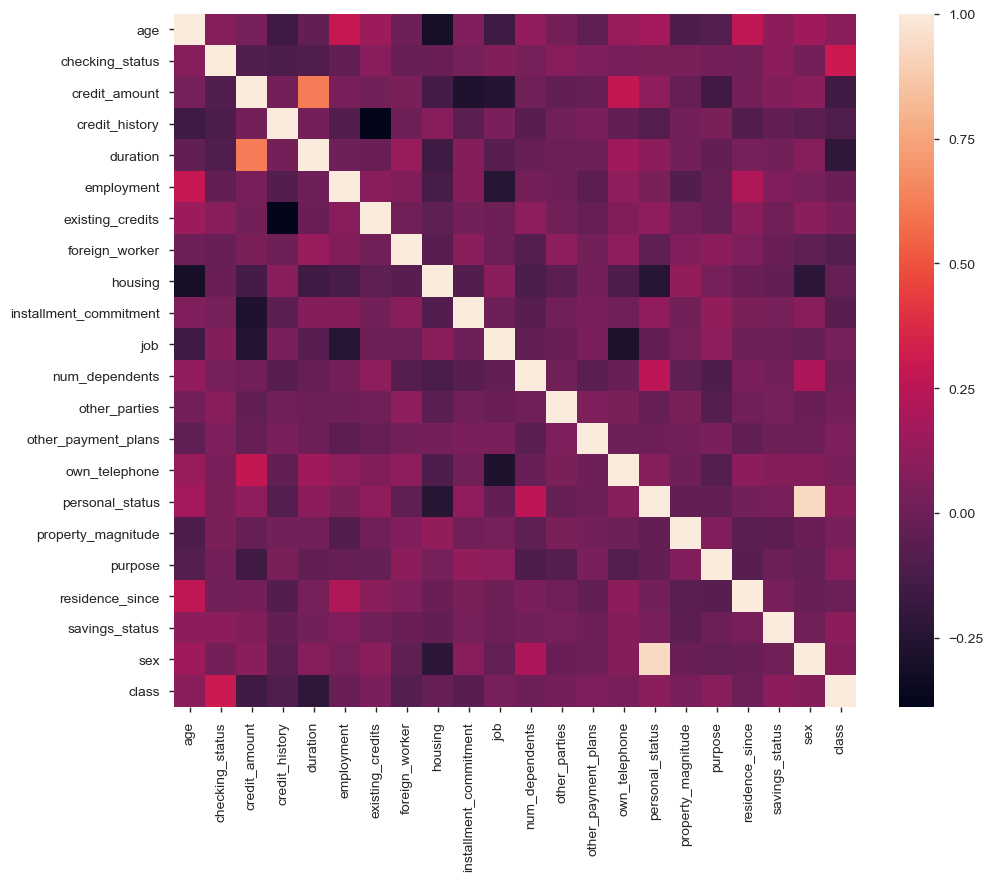

In [13]:
plt.subplots(figsize=(11, 9))
sns.heatmap(data_credit_lb.corr())

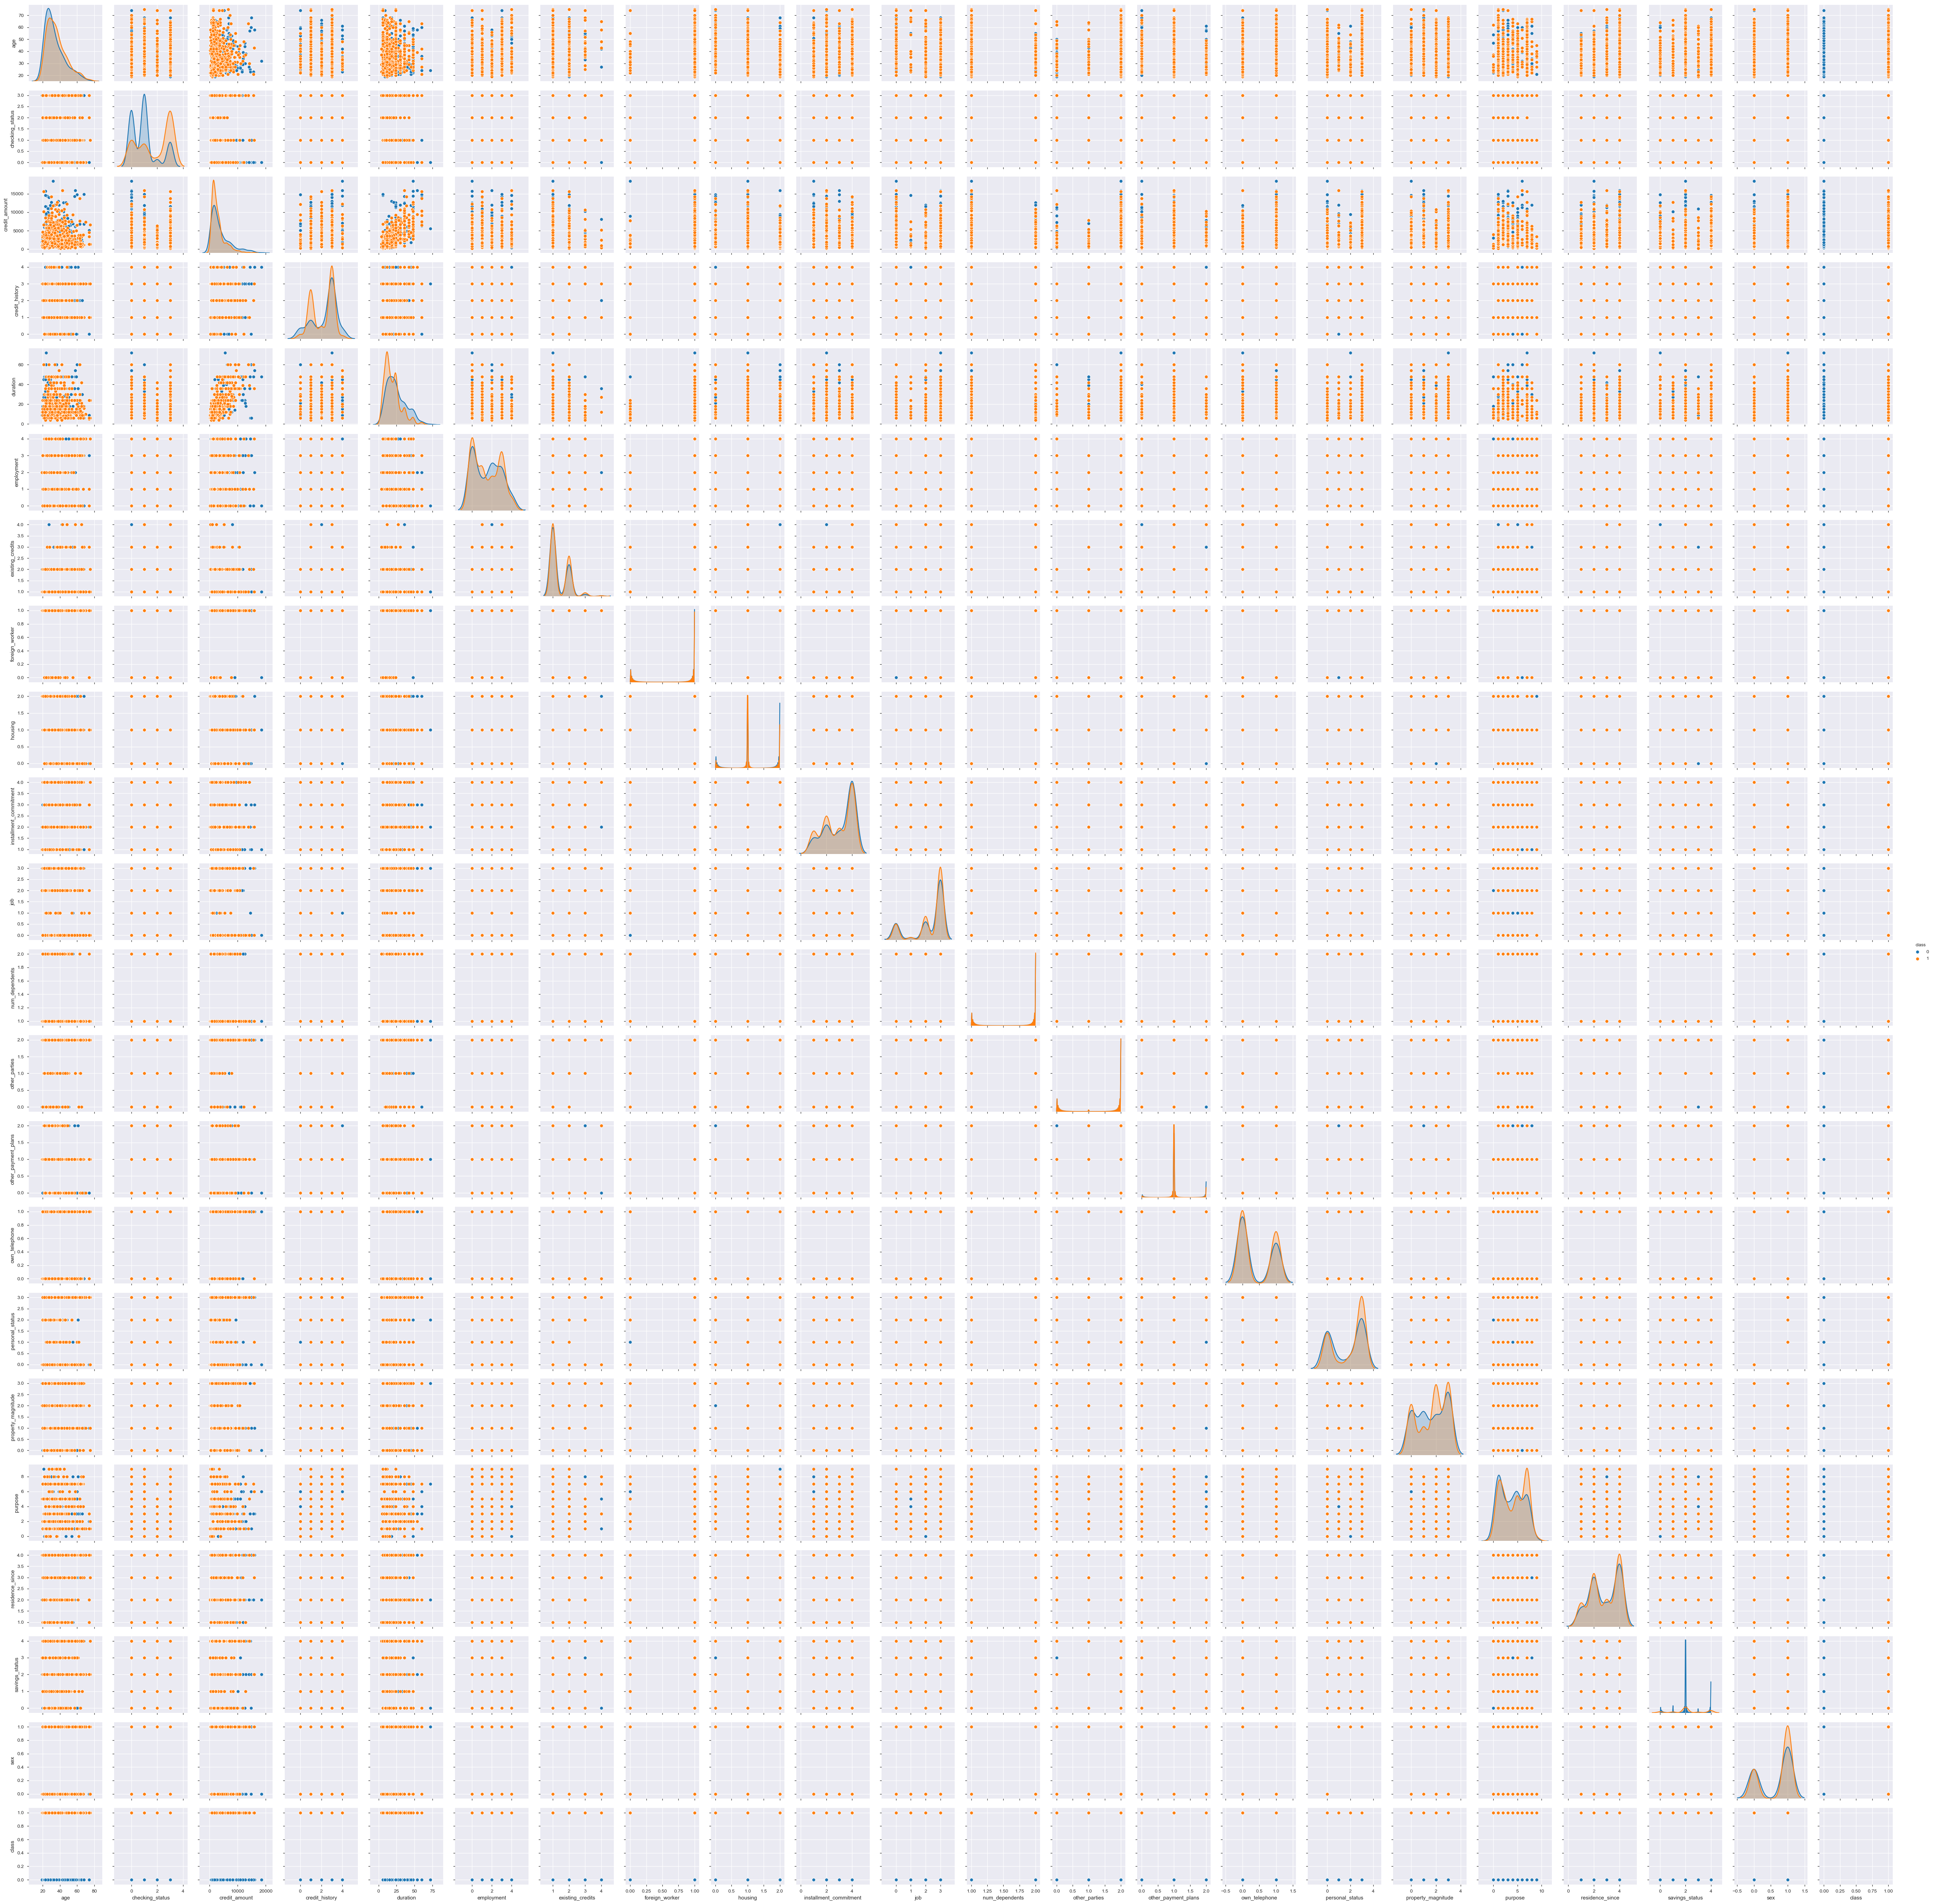

In [14]:
sns_plot = sns.pairplot(data_credit_lb, diag_kind="kde",hue='class')
sns_plot.savefig("plot_credit_lbl.png")

## Escalonando

In [15]:
# Data sem escalonar
data_np_x = data_credit_lb.drop(columns=['class']).to_numpy()
data_np_y = data_credit_lb['class'].to_numpy()

In [16]:
scaler = StandardScaler().fit(data_np_x)
data_np_x = scaler.transform(data_np_x)

## Classificando

## Funções necessárias

In [17]:
folds_value = 10

In [18]:
def calcula_metricas(metricas, y_test, y_predict):
    metricas['acc'] += (accuracy_score(y_test, y_predict))
    metricas['recall'] += (recall_score(y_test, y_predict))
    metricas['precision'] += (precision_score(y_test, y_predict))
    metricas['f1'] += f1_score(y_test, y_predict)
    metricas['roc'] += roc_auc_score(y_test, y_predict)
    metricas['kappa'] += cohen_kappa_score(y_test, y_predict)
    metricas['balanced_acc'] += balanced_accuracy_score(y_test, y_predict)

In [19]:
def save_metricas(name, metricas):
    f = open(name, 'w')
    f.write('Acuária:' + str(metricas['acc']) + '\n')
    f.write('Recall:' + str(metricas['recall']) + '\n') 
    f.write('Precisão:' + str(metricas['precision']) + '\n')  
    f.write('F-Measure:' + str(metricas['f1']) + '\n')
    f.write('Curva Roc:' + str(metricas['roc']) + '\n')
    f.write('Indice Kappa:' + str(metricas['kappa']) + '\n')  
    f.write('Acuária Balanceada:' + str(metricas['balanced_acc']) + '\n') 
    f.close()

In [20]:
def show_metricas(metricas):
    print('Acuária:', metricas['acc'])
    print('Recall:', metricas['recall'])
    print('Precisão:', metricas['precision'])
    print('F-Measure:', metricas['f1'])
    print('Curva Roc:', metricas['roc'])
    print('Indice Kappa:', metricas['kappa'])
    print('Acuária Balanceada:', metricas['balanced_acc'])

In [21]:
def write_metricas(name_file, metricas, metodo):  
    f = open(name_file, "a")
    f.write(metodo + ';')
    f.write(str(round(metricas['acc'],4)) + ';')
    f.write(str(round(metricas['recall'],4)) + ';')
    f.write(str(round(metricas['precision'],4)) + ';')
    f.write(str(round(metricas['f1'],4)) + ';')
    f.write(str(round(metricas['roc'],4)) + ';')
    f.write(str(round(metricas['kappa'],4)) + ';')    
    f.write(str(round(metricas['balanced_acc'],4)) + '\n')
    f.close()

## Aplicando KNN com K-fold

## DataFrame Cru

In [22]:
formato = 'Cru'

In [23]:
folds_value = 10

In [24]:
kf = KFold(n_splits=10, shuffle=True, random_state=random.randint(0, 10))
data_kfold = kf.split(data_np_x)

train = []
test = []

for train_index, test_index in data_kfold:
    train.append(train_index)
    test.append(test_index)

In [25]:
name_file = 'metricas-' + formato + '.csv'

f = open(name_file, "w")
f.write(';Acurácia;Recall;Precisão;F1;Roc;Kappa;Acurácia Balanceada\n')
f.close()

## Aplicando KNN com K-fold

In [26]:
metodo = 'KNN'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(x_train, y_train)

    y_predict = neigh.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.667
Recall: 0.7861261188753572
Precisão: 0.7484957884013399
F-Measure: 0.7661153571336496
Curva Roc: 0.5875810628023066
Indice Kappa: 0.1792183363179038
Acuária Balanceada: 0.5875810628023066


## Aplicando GaussianNB com K-fold

In [27]:
metodo = 'Gauss'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    gauss = GaussianNB()
    gauss.fit(x_train, y_train)
    
    y_predict = gauss.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.6890000000000001
Recall: 0.7618699844344405
Precisão: 0.7949540364472436
F-Measure: 0.7729787908572685
Curva Roc: 0.6487859069288866
Indice Kappa: 0.28046520330743563
Acuária Balanceada: 0.6487859069288866


## Aplicando DecisionTreeClassifier com K-fold

In [28]:
metodo = 'Tree'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    y_predict = tree.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.6950000000000001
Recall: 0.771866604583279
Precisão: 0.7854832341718693
F-Measure: 0.7771118530772865
Curva Roc: 0.6412260728515466
Indice Kappa: 0.2811079450129389
Acuária Balanceada: 0.6412260728515466


## Aplicando SVM com K-fold

In [29]:
metodo = 'SVM'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    svm = SVC()
    svm.fit(x_train, y_train)
    
    y_predict = svm.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)


Acuária: 0.7460000000000001
Recall: 0.937453897891975
Precisão: 0.7572620096287589
F-Measure: 0.8369579580637951
Curva Roc: 0.6182334230294194
Indice Kappa: 0.2780091570633585
Acuária Balanceada: 0.6182334230294194


## DataFrame Selecionado

### Selecionando atributos

In [31]:
data_select = data_credit_lb[['age','credit_amount','credit_history']]

In [32]:
data_np_x = data_select.to_numpy()
data_np_y = data_credit_lb['class'].to_numpy()

In [33]:
scaler = StandardScaler().fit(data_np_x)
data_np_x = scaler.transform(data_np_x)

## Aplicando

In [35]:
formato = 'Selecionado'

In [36]:
kf = KFold(n_splits=10, shuffle=True, random_state=random.randint(0, 10))
data_kfold = kf.split(data_np_x)

train = []
test = []

for train_index, test_index in data_kfold:
    train.append(train_index)
    test.append(test_index)

In [37]:
name_file = 'metricas-' + formato + '.csv'

f = open(name_file, "w")
f.write(';Acurácia;Recall;Precisão;F1;Roc;Kappa;Acurácia Balanceada\n')
f.close()

## Aplicando KNN com K-fold

In [38]:
metodo = 'KNN'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(x_train, y_train)

    y_predict = neigh.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.628
Recall: 0.7340769232336475
Precisão: 0.7351502043587164
F-Measure: 0.7334090073511181
Curva Roc: 0.5578400225857234
Indice Kappa: 0.11274928271974041
Acuária Balanceada: 0.5578400225857234


## Aplicando GaussianNB com K-fold

In [39]:
metodo = 'Gauss'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    gauss = GaussianNB()
    gauss.fit(x_train, y_train)
    
    y_predict = gauss.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.704
Recall: 0.940412783538676
Precisão: 0.7219515928388632
F-Measure: 0.816057832809539
Curva Roc: 0.547566475831035
Indice Kappa: 0.1180194995792841
Acuária Balanceada: 0.547566475831035


## Aplicando DecisionTreeClassifier com K-fold

In [40]:
metodo = 'Tree'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    y_predict = tree.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.6080000000000001
Recall: 0.7045205059143995
Precisão: 0.7254031765999808
F-Measure: 0.7138764505704455
Curva Roc: 0.5426245796400748
Indice Kappa: 0.08333851389889967
Acuária Balanceada: 0.5426245796400748


## Aplicando SVM com K-fold

In [41]:
metodo = 'SVM'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    svm = SVC()
    svm.fit(x_train, y_train)
    
    y_predict = svm.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)


Acuária: 0.6940000000000001
Recall: 0.9505694099183885
Precisão: 0.7110855036966002
F-Measure: 0.8127522669762838
Curva Roc: 0.5237673956555946
Indice Kappa: 0.05857543003277889
Acuária Balanceada: 0.5237673956555946
